# Tugas 2 - Implementasi Arsitektur Transformer

Marchel Rianra Glendrikho Simanjuntak

22/494013/TK/54157

## Library Numpy

In [165]:
import numpy as np

## Token Embedding

Token Embedding berfungsi untuk mengubah indeks token hasil tokenisasi menjadi representasi vektor berdimensi tinggi (`d_model`).
Setiap token memiliki vektor unik yang disimpan dalam sebuah matriks embedding berukuran (`vocab_size`, `d_model`), di mana:



*   `vocab_size` adalah jumlah total token unik dalam kosakata,
*   `d_model` adalah dimensi representasi vektor untuk setiap token.


Bobot pada matriks embedding diinisialisasi secara acak dan dibagi dengan √d_model agar nilai awalnya tetap stabil (menghindari nilai yang terlalu besar atau kecil).

Setelah itu, saat input berupa urutan token (misalnya [2, 5, 8]), model akan mengambil baris ke-2, ke-5, dan ke-8 dari matriks embedding untuk menghasilkan representasi vektor yang setara.

In [166]:
class TokenEmbedding:
    def __init__(self, vocab_size, d_model):
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.embeddings = np.random.randn(vocab_size, d_model) / np.sqrt(d_model)

    def __call__(self, x):
        return self.embeddings[x]


## Positional Encoding (Sinusoidal)

Positional Encoding digunakan untuk memberikan informasi posisi pada setiap token dalam sebuah urutan.
Karena arsitektur Transformer tidak memproses data secara berurutan seperti RNN,
model ini memerlukan representasi eksplisit dari posisi token agar dapat memahami urutan dan hubungan antar kata.

Positional Encoding menghasilkan vektor berdimensi sama dengan token embedding ($d_{model}$),
sehingga dapat dijumlahkan secara langsung dengan hasil embedding token.
Nilai pada encoding ini dihitung menggunakan fungsi sinus dan kosinus dengan frekuensi yang berbeda untuk setiap dimensi,
dengan rumus sebagai berikut:

\begin{equation}
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)
\end{equation}

\begin{equation}
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)
\end{equation}

dengan:

* $pos$ adalah posisi token dalam urutan (misalnya 0, 1, 2),
* $i$ adalah indeks dimensi dari vektor embedding.


Fungsi sinus dan kosinus dengan frekuensi berbeda ini memastikan setiap posisi memiliki pola representasi yang unik,
dan perbedaan antar posisi tetap dapat dikenali oleh model.
Dengan demikian, model Transformer mampu menangkap hubungan relatif antar token (misalnya jarak antar kata dalam kalimat).


In [167]:
class PositionalEncoding:
    def __init__(self, d_model, max_len=5000):
        pe = np.zeros((max_len, d_model))
        position = np.arange(0, max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.pe = pe

    def __call__(self, x):
        seq_len = x.shape[1]
        return x + self.pe[:seq_len]


##Scaled Dot-Product Attention

Mekanisme *Scaled Dot-Product Attention* merupakan komponen utama dalam arsitektur Transformer
yang memungkinkan model untuk memfokuskan perhatian *attention* pada token-token tertentu dalam suatu urutan input.
Konsep utamanya adalah menghitung seberapa besar relevansi antara setiap pasangan token melalui operasi dot product antar vektor.

Setiap token diubah menjadi tiga representasi vektor berbeda:

* Query ($Q$) – merepresentasikan token yang sedang diperhatikan,
* Key ($K$) – merepresentasikan token yang menjadi referensi atau konteks,
* Value ($V$) – membawa informasi aktual dari token.


Skor perhatian dihitung dengan melakukan operasi dot product antara setiap pasangan $Q$ dan $K$,
yang kemudian diskalakan dengan faktor $\sqrt{d_k}$ untuk menstabilkan nilai gradien ketika dimensi vektor besar.  
Langkah-langkah perhitungannya dapat dirumuskan sebagai berikut:

\begin{equation}
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^{T}}{\sqrt{d_k}} \right) V
\end{equation}

dengan:
* $Q$ : matriks *query* berukuran $(n_{query} \times d_k)$,
* $K$ : matriks *key* berukuran $(n_{key} \times d_k)$,
* $V$ : matriks *value* berukuran $(n_{key} \times d_v)$,
* $d_k$ : dimensi vektor *key* dan *query*.

Proses perhitungan:

* Hitung skor kesesuaian antara setiap token query dan seluruh token key menggunakan operasi $QK^{T}$.
* Skor kemudian dibagi dengan $\sqrt{d_k}$ untuk menghindari nilai dot product yang terlalu besar.
* Terapkan fungsi *softmax* untuk mengubah skor menjadi distribusi probabilitas perhatian.
* Kalikan hasil distribusi dengan matriks $V$ untuk menghasilkan representasi kontekstual akhir.

Mekanisme ini memungkinkan setiap token untuk menyesuaikan bobot perhatian terhadap token lain,
sehingga model dapat menangkap hubungan antar kata yang jauh dalam sebuah kalimat tanpa kehilangan konteks lokal.


In [168]:
import matplotlib.pyplot as plt

def scaled_dot_product_attention(Q, K, V, mask=None, visualize=False):
    d_k = Q.shape[-1]
    scores = np.matmul(Q, K.transpose(0,1,3,2)) / np.sqrt(d_k)

    if mask is not None:
        scores = scores + (mask * -1e9)

    scores_exp = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
    weights = scores_exp / np.sum(scores_exp, axis=-1, keepdims=True)

    output = np.matmul(weights, V)

    if visualize:
        attn_map = weights[0, 0]
        plt.figure(figsize=(5,4))
        plt.imshow(attn_map, cmap='viridis', interpolation='nearest')
        plt.title("Attention weights (batch=0, head=0)")
        plt.xlabel("Key positions")
        plt.ylabel("Query positions")
        plt.colorbar(label="attention")
        plt.show()

    return output, weights

## Multi-Head Attention

*Multi-Head Attention* merupakan pengembangan dari mekanisme *Scaled Dot-Product Attention*
yang memungkinkan model untuk memperhatikan berbagai konteks atau hubungan antar token secara paralel.  
Alih-alih hanya memiliki satu set vektor $Q$, $K$, dan $V$,
pada *Multi-Head Attention* vektor-vektor tersebut dibagi menjadi beberapa *head*,
sehingga model dapat mempelajari informasi dari berbagai representasi subruang (*subspaces*) yang berbeda.

Secara formal, prosesnya dapat dijelaskan sebagai berikut.  
Pertama, untuk setiap *head* $i$, dilakukan proyeksi linear terhadap input menjadi vektor $Q_i$, $K_i$, dan $V_i$:

\begin{equation}
Q_i = XW_i^Q, \quad K_i = XW_i^K, \quad V_i = XW_i^V
\end{equation}

dengan:
* $X$ adalah input embedding atau hasil dari lapisan sebelumnya,
* $W_i^Q, W_i^K, W_i^V$ adalah matriks bobot proyeksi untuk head ke-$i$.

Setiap *head* kemudian menghitung *Scaled Dot-Product Attention* secara independen:

\begin{equation}
\text{head}_i = \text{Attention}(Q_i, K_i, V_i) = \text{softmax}\left( \frac{Q_i K_i^T}{\sqrt{d_k}} \right) V_i
\end{equation}

Hasil dari seluruh *head* kemudian dikonkatenasi dan diproyeksikan kembali ke ruang berdimensi $d_{model}$:

\begin{equation}
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \text{head}_2, \ldots, \text{head}_h) W^O
\end{equation}

dengan:

* $h$ adalah jumlah *head*,
* $W^O$ adalah matriks bobot output untuk menggabungkan hasil seluruh *head*.


In [169]:
class MultiHeadAttention:
    def __init__(self, d_model, num_heads):
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads

        self.Wq = np.random.randn(d_model, d_model) / np.sqrt(d_model)
        self.Wk = np.random.randn(d_model, d_model) / np.sqrt(d_model)
        self.Wv = np.random.randn(d_model, d_model) / np.sqrt(d_model)
        self.Wo = np.random.randn(d_model, d_model) / np.sqrt(d_model)

    def split_heads(self, x):
        batch, seq_len, d_model = x.shape
        x = x.reshape(batch, seq_len, self.num_heads, self.depth)
        return x.transpose(0, 2, 1, 3)

    def __call__(self, Q, K, V, mask=None, visualize=False):
        Q = np.matmul(Q, self.Wq)
        K = np.matmul(K, self.Wk)
        V = np.matmul(V, self.Wv)

        Qh = self.split_heads(Q)
        Kh = self.split_heads(K)
        Vh = self.split_heads(V)

        attn_out, attn_weights = scaled_dot_product_attention(Qh, Kh, Vh, mask, visualize=visualize)

        attn_out = attn_out.transpose(0, 2, 1, 3).reshape(Q.shape[0], -1, self.d_model)
        out = np.matmul(attn_out, self.Wo)
        return out

## Feed Forward Network

Setelah proses *Multi-Head Attention*, setiap token dalam urutan masukan diproses secara independen oleh
*Feed Forward Network* (FFN).
Komponen ini berfungsi untuk melakukan transformasi non-linear pada representasi tiap token,
sehingga model dapat mempelajari hubungan yang lebih kompleks antar fitur dalam ruang representasi.

Feed Forward Network terdiri atas dua lapisan linear dengan fungsi aktivasi non-linear (*Rectified Linear Unit* atau ReLU) di antara keduanya.
Secara matematis, operasi FFN dapat dituliskan sebagai berikut:

\begin{equation}
\text{FFN}(x) = \max(0,\, xW_1 + b_1)W_2 + b_2
\end{equation}

dengan:
* $x$ : representasi input dari setiap token (berukuran $d_{model}$),
* $W_1 \in \mathbb{R}^{d_{model} \times d_{ff}}$ dan $W_2 \in \mathbb{R}^{d_{ff} \times d_{model}}$ : matriks bobot lapisan pertama dan kedua,
* $b_1$ dan $b_2$ : vektor bias untuk masing-masing lapisan,
* $d_{ff}$ : dimensi ruang tersembunyi (\textit{hidden dimension}), biasanya lebih besar dari $d_{model}$.

Lapisan pertama memperluas dimensi representasi dari $d_{model}$ menjadi $d_{ff}$,
sedangkan lapisan kedua mengembalikannya kembali ke ukuran semula.
Fungsi aktivasi ReLU ($\max(0, \cdot)$) memberikan sifat non-linear yang membantu model dalam menangkap pola yang lebih kompleks dan meningkatkan kemampuan generalisasi.

Karakteristik:
* FFN diaplikasikan secara identik dan independen pada setiap posisi token.
* Tidak ada interaksi antar token di dalam FFN, sehingga operasi ini bersifat *position-wise*.
* Kombinasi antara *Multi-Head Attention* dan FFN membentuk satu blok utama (*Transformer Block*) dalam arsitektur Transformer.


In [170]:
class FeedForward:
    def __init__(self, d_model, d_ff):
        self.W1 = np.random.randn(d_model, d_ff) / np.sqrt(d_model)
        self.b1 = np.zeros((d_ff,))
        self.W2 = np.random.randn(d_ff, d_model) / np.sqrt(d_ff)
        self.b2 = np.zeros((d_model,))

    def __call__(self, x):
        h = np.maximum(0, x @ self.W1 + self.b1)
        return h @ self.W2 + self.b2

## Layer Normalization

*Layer Normalization* merupakan teknik normalisasi yang digunakan dalam setiap blok Transformer
untuk menstabilkan distribusi aktivasi dan mempercepat proses pelatihan.  
Berbeda dengan *Batch Normalization* yang melakukan normalisasi antar sampel dalam satu batch,
*Layer Normalization* bekerja dengan menormalkan nilai aktivasi di sepanjang dimensi fitur untuk setiap token secara individual.

Secara matematis, operasi *Layer Normalization* terhadap sebuah vektor input $x \in \mathbb{R}^{d_{model}}$ didefinisikan sebagai:

\begin{equation}
\text{LayerNorm}(x) = \gamma \left( \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} \right) + \beta
\end{equation}

dengan:
* $\mu = \frac{1}{d_{model}} \sum_{i=1}^{d_{model}} x_i$ : rata-rata nilai fitur,
* $\sigma^2 = \frac{1}{d_{model}} \sum_{i=1}^{d_{model}} (x_i - \mu)^2$ : varians nilai fitur,
* $\epsilon$ : nilai kecil untuk mencegah pembagian dengan nol,
* $\gamma$ dan $\beta$ : parameter yang dapat dipelajari untuk melakukan skala dan pergeseran (re-scaling dan re-centering).

Tujuan:

Normalisasi ini memastikan bahwa distribusi nilai aktivasi tetap stabil di setiap lapisan,
mengurangi masalah seperti *vanishing* atau *exploding gradient*,
dan membantu model mencapai konvergensi yang lebih cepat selama proses pelatihan.

Penerapan pada Transformer:

Dalam arsitektur Transformer, *Layer Normalization* diterapkan sebelum atau sesudah operasi utama seperti
*Multi-Head Attention* dan *Feed Forward Network*,
sering kali dalam kombinasi dengan *residual connection8 sebagai berikut:

\begin{equation}
x' = \text{LayerNorm}(x + \text{Sublayer}(x))
\end{equation}

dengan $\text{Sublayer}(x)$ merupakan salah satu komponen utama Transformer (seperti MHA atau FFN).
Kombinasi antara residual connection dan normalisasi menjaga stabilitas informasi antar lapisan serta memperbaiki aliran gradien selama pelatihan.


In [171]:
class LayerNorm:
    def __init__(self, d_model, eps=1e-6):
        self.gamma = np.ones((d_model,))
        self.beta = np.zeros((d_model,))
        self.eps = eps

    def __call__(self, x):
        mean = np.mean(x, axis=-1, keepdims=True)
        var = np.var(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / np.sqrt(var + self.eps) + self.beta

## Decoder Block (dengan Causal Mask)

*Decoder Block* merupakan komponen utama dari bagian *decoder* pada arsitektur Transformer.  
Setiap blok terdiri dari beberapa sublapisan, yaitu:
* *Masked Multi-Head Self-Attention* dengan *causal mask*,
* *Feed Forward Network* (FFN),
* serta *Layer Normalization* dan *Residual Connection* pada setiap sublapisan.

Fungsi utama:

Decoder berperan menghasilkan token keluaran secara autoregresif,
artinya setiap token hanya boleh bergantung pada token-token sebelumnya dalam urutan output.  
Untuk menerapkan sifat ini, digunakan **causal mask** yang menutupi (*mask*) posisi masa depan dalam perhitungan perhatian.

Causal Mask:

Causal mask adalah matriks segitiga atas (*upper-triangular matrix*) yang berisi nilai nol di bawah diagonal dan satu di atasnya.
Matriks ini digunakan untuk mencegah model melihat token masa depan.  
Secara matematis, mask dapat dituliskan sebagai:

\begin{equation}
M_{ij} =
\begin{cases}
0, & \text{jika } j \leq i \\
1, & \text{jika } j > i
\end{cases}
\end{equation}

Mask ini kemudian diterapkan pada skor perhatian sebelum fungsi *softmax* sebagai berikut:

\begin{equation}
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^{T}}{\sqrt{d_k}} + M \right)V
\end{equation}

Posisi dengan nilai 1 (di atas diagonal) akan diberikan penalti sangat besar (biasanya $-10^9$),
sehingga hasil *softmax* pada posisi tersebut mendekati nol.  
Dengan demikian, setiap token hanya dapat memperhatikan dirinya sendiri dan token sebelumnya.

Struktur Decoder Block:
Setiap blok decoder memiliki aliran data sebagai berikut:

\begin{equation}
\begin{aligned}
x_1 &= \text{LayerNorm}(x + \text{MaskedMultiHeadAttention}(x, x, x, M)) \\
x_2 &= \text{LayerNorm}(x_1 + \text{FeedForward}(x_1))
\end{aligned}
\end{equation}

Pada persamaan tersebut:
* $x$ : representasi input token yang telah melalui embedding dan positional encoding,
* $M$ : *causal mask*,
* $\text{MaskedMultiHeadAttention}$ : operasi perhatian dengan pembatasan pada masa depan,
* $\text{FeedForward}$ : jaringan non-linear untuk transformasi representasi.

Intuisi:
Dengan penerapan *causal mask*, setiap token dalam decoder hanya dapat mengakses informasi dari token yang muncul sebelumnya.
Hal ini memastikan bahwa prediksi dilakukan secara bertahap, menyerupai cara kerja model generatif autoregresif seperti GPT,
di mana token di posisi $t$ hanya dipengaruhi oleh token di posisi $<t$.

Kesimpulan:

*Decoder Block* dengan *Causal Mask* memastikan aliran informasi bersifat satu arah (kiri ke kanan),
mempertahankan sifat autoregresif Transformer, dan memungkinkan proses prediksi token secara berurutan tanpa kebocoran informasi dari masa depan.


In [172]:
class DecoderBlock:
    def __init__(self, d_model, num_heads, d_ff):
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff)
        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)

    def __call__(self, x, mask, visualize=False):
        attn_out = self.mha(x, x, x, mask, visualize=visualize)
        x = self.norm1(x + attn_out)
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        return x

## Rotary Positional Encoding (RoPE)

Sebagai alternatif dari *sinusoidal positional encoding*,
Rotary Positional Encoding (RoPE) memperkenalkan informasi posisi relatif
melalui rotasi vektor embedding pada ruang dua dimensi untuk setiap pasangan dimensi fitur.

RoPE tidak menambahkan nilai posisi secara langsung ke embedding,
melainkan menerapkan transformasi rotasi berikut pada setiap pasangan dimensi:

\begin{equation}
\text{RoPE}(x, pos) =
\begin{bmatrix}
x_{2i} \cos \theta_{pos, i} - x_{2i+1} \sin \theta_{pos, i} \\
x_{2i} \sin \theta_{pos, i} + x_{2i+1} \cos \theta_{pos, i}
\end{bmatrix}
\end{equation}

dengan:
\begin{equation}
\theta_{pos, i} = \frac{pos}{10000^{2i/d_{model}}}
\end{equation}

Pendekatan ini membuat Transformer mampu mengenali hubungan posisi relatif antar token,
yang terbukti meningkatkan generalisasi dan efisiensi model pada berbagai tugas generatif.


In [173]:
class RotaryPositionalEncoding:
    def __init__(self, d_model, max_len=5000):
        assert d_model % 2 == 0, "d_model harus genap untuk RoPE"
        self.d_model = d_model
        self.max_len = max_len
        self.inv_freq = 1.0 / (10000 ** (np.arange(0, d_model, 2) / d_model))

    def get_angles(self, positions):
        return np.einsum('i,j->ij', positions, self.inv_freq)

    def __call__(self, x):
        batch, seq_len, d_model = x.shape
        positions = np.arange(seq_len)
        angles = self.get_angles(positions)
        sin, cos = np.sin(angles), np.cos(angles)
        sin = np.repeat(sin[np.newaxis, :, :], batch, axis=0)
        cos = np.repeat(cos[np.newaxis, :, :], batch, axis=0)

        x1 = x[:, :, 0::2]
        x2 = x[:, :, 1::2]

        x_rot = np.zeros_like(x)
        x_rot[:, :, 0::2] = x1 * cos - x2 * sin
        x_rot[:, :, 1::2] = x1 * sin + x2 * cos

        return x_rot


## Full Decoder Transformer Model

*Transformer Decoder* merupakan komponen utama dalam arsitektur Transformer yang berfungsi menghasilkan keluaran (*output sequence*) secara autoregresif,
yaitu dengan memprediksi satu token pada satu waktu berdasarkan konteks token-token sebelumnya.  
Arsitektur ini terdiri atas beberapa blok decoder yang disusun secara berurutan, di mana setiap blok memiliki komponen inti berupa:
* *Masked Multi-Head Self-Attention* dengan *causal mask,
* *Feed Forward Network* (FFN),
*  serta *Layer Normalization* dan *Residual Connection*.

Struktur umum model:

Sebelum memasuki blok decoder, setiap token input terlebih dahulu diubah menjadi representasi vektor melalui *token embedding* dan ditambahkan dengan *positional encoding* untuk memasukkan informasi urutan posisi.  
Secara matematis:

\begin{equation}
X_0 = \text{TokenEmbedding}(input) + \text{PositionalEncoding}(input)
\end{equation}

Selanjutnya, representasi $X_0$ melewati $N$ buah blok decoder secara berurutan:

\begin{equation}
X_l = \text{DecoderBlock}(X_{l-1}), \quad l = 1, 2, \ldots, N
\end{equation}

Setiap *DecoderBlock* menggunakan *Causal Mask* agar setiap token hanya memperhatikan token sebelumnya.
Setelah melalui seluruh blok, keluaran akhir $X_N$ diproyeksikan ke ruang vektor kosakata (*vocabulary space*) menggunakan lapisan linear yang bobotnya sering kali diikat (*weight tying*) dengan matriks embedding awal:

\begin{equation}
\text{Logits} = X_N W_E^T
\end{equation}

dengan:

* $W_E$ : matriks bobot embedding berukuran $(vocab\_size \times d_{model})$,
* $\text{Logits}$ : representasi skor sebelum fungsi *softmax*.

Distribusi probabilitas token keluaran diperoleh melalui fungsi *softmax*:

\begin{equation}
P(y_t|y_{<t}) = \text{softmax}(\text{Logits})
\end{equation}

Proses ini kemudian diulang secara autoregresif untuk setiap langkah $t$,
di mana token hasil prediksi pada langkah sebelumnya digunakan sebagai masukan untuk langkah berikutnya.

Ringkasan alur data:

* Token input diubah menjadi embedding dan ditambahkan dengan positional encoding.
* Representasi hasilnya melewati $N$ buah blok decoder secara berurutan.
* Setiap blok terdiri dari:
  * Masked Multi-Head Self-Attention (dengan Causal Mask),
  * Feed Forward Network (FFN),
  * Layer Normalization dan Residual Connection.
* Output terakhir diproyeksikan ke ruang kosakata untuk menghasilkan distribusi probabilitas token berikutnya.

Causal Masking:

Causal Mask memastikan bahwa token pada posisi $t$ hanya dapat mengakses informasi dari token posisi $<t$,
sehingga model memproses urutan secara satu arah (*left-to-right*).  
Hal ini menjadikan Decoder Transformer cocok untuk tugas-tugas generatif seperti prediksi teks atau penyusunan kalimat.

Kesimpulan:

*Full Decoder Transformer Model* memanfaatkan mekanisme perhatian berlapis yang dilengkapi dengan normalisasi, koneksi residual, dan causal masking.
Kombinasi ini memungkinkan model untuk memahami konteks jangka panjang dan menghasilkan token secara berurutan tanpa kebocoran informasi dari masa depan.


In [174]:
class TransformerDecoder:
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_len=100, use_rope=False):
        self.token_emb = TokenEmbedding(vocab_size, d_model)
        self.use_rope = use_rope

        if use_rope:
            self.pos_enc = RotaryPositionalEncoding(d_model, max_len)
        else:
            self.pos_enc = PositionalEncoding(d_model, max_len)

        self.layers = [DecoderBlock(d_model, num_heads, d_ff) for _ in range(num_layers)]
        self.out_proj = self.token_emb.embeddings.T

    def causal_mask(self, seq_len):
        mask = np.triu(np.ones((1,1,seq_len,seq_len)), k=1)
        return mask

    def __call__(self, x, visualize=False):
        x = self.token_emb(x)
        x = self.pos_enc(x)
        mask = self.causal_mask(x.shape[1])
        for i, layer in enumerate(self.layers):
            visualize_layer = visualize and (i == 0)
            x = layer(x, mask, visualize=visualize_layer)
        logits = np.matmul(x, self.out_proj)
        probs = np.exp(logits - np.max(logits, axis=-1, keepdims=True))
        probs = probs / np.sum(probs, axis=-1, keepdims=True)
        return logits, probs, mask

## Pengujian dan Bukti Uji

### Menggunakan Sinusoidal

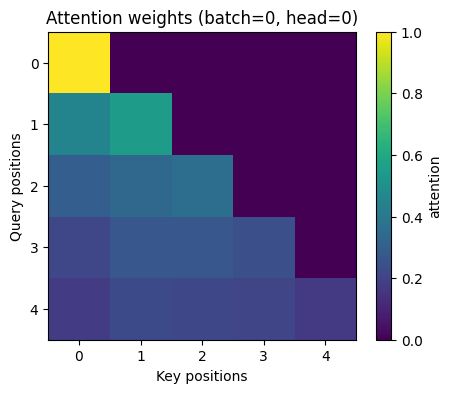

In [175]:
vocab_size = 50
d_model = 32
num_heads = 4
d_ff = 64
num_layers = 2
seq_len = 5
batch_size = 2

model = TransformerDecoder(vocab_size, d_model, num_heads, d_ff, num_layers, max_len=seq_len, use_rope=False)
input_tokens = np.random.randint(0, vocab_size, (batch_size, seq_len))

logits, probs, mask = model(input_tokens, visualize=True)


In [176]:
print("Input tokens:\n", input_tokens)
print("Logits shape:", logits.shape)
print("Probs shape:", probs.shape)
print("Causal mask:\n", mask[0,0])

Input tokens:
 [[35 23 45 34  2]
 [31 28  3 42 42]]
Logits shape: (2, 5, 50)
Probs shape: (2, 5, 50)
Causal mask:
 [[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]


In [177]:
print("Softmax output (last token):\n", probs[:, -1, :])

Softmax output (last token):
 [[0.01470529 0.02943893 0.03996792 0.00438154 0.01795223 0.21577204
  0.0211633  0.00288275 0.01109746 0.02932197 0.0364767  0.03148109
  0.02973782 0.00418463 0.00333082 0.01666515 0.0036428  0.03942976
  0.00169865 0.00531376 0.00444233 0.0353729  0.00464647 0.07512307
  0.00672827 0.01215691 0.00722267 0.00430505 0.01704991 0.00291919
  0.00653348 0.00851243 0.01872911 0.02346289 0.00393078 0.04947336
  0.00704856 0.0326903  0.01265153 0.00774252 0.02107879 0.00537133
  0.0073991  0.00145162 0.01538115 0.00679191 0.00070818 0.00106903
  0.00856353 0.03279902]
 [0.01629901 0.04584399 0.0264367  0.00399849 0.0173386  0.16576632
  0.0211576  0.00276    0.01035431 0.03254556 0.03666386 0.02587795
  0.03063149 0.00559943 0.00564704 0.02177936 0.00365384 0.0358542
  0.0021208  0.00906146 0.00507922 0.0434369  0.00466905 0.0781325
  0.00577963 0.01018889 0.00868468 0.00510768 0.01571435 0.00348409
  0.00958024 0.00704342 0.01802953 0.0208224  0.0041653  0.0420

In [178]:
print("Sum of probabilities (should be 1):", np.sum(probs[:, -1, :], axis=-1))

Sum of probabilities (should be 1): [1. 1.]


### Menggunakan RoPE

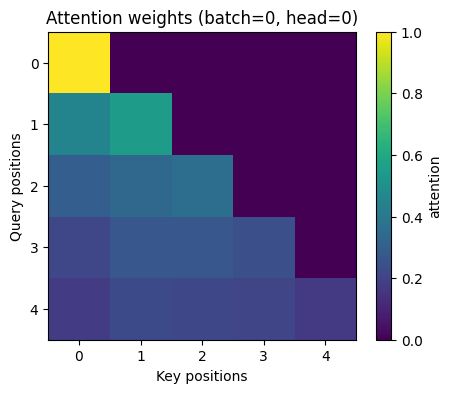

In [179]:
model_rope = TransformerDecoder(vocab_size, d_model, num_heads, d_ff, num_layers, max_len=seq_len, use_rope=True)

logits, probs, mask = model(input_tokens, visualize=True)

In [180]:
print("Input tokens:\n", input_tokens)
print("Logits shape:", logits.shape)
print("Probs shape:", probs.shape)
print("Causal mask:\n", mask[0,0])

Input tokens:
 [[35 23 45 34  2]
 [31 28  3 42 42]]
Logits shape: (2, 5, 50)
Probs shape: (2, 5, 50)
Causal mask:
 [[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]


In [181]:
print("Softmax output (last token):\n", probs[:, -1, :])

Softmax output (last token):
 [[0.01470529 0.02943893 0.03996792 0.00438154 0.01795223 0.21577204
  0.0211633  0.00288275 0.01109746 0.02932197 0.0364767  0.03148109
  0.02973782 0.00418463 0.00333082 0.01666515 0.0036428  0.03942976
  0.00169865 0.00531376 0.00444233 0.0353729  0.00464647 0.07512307
  0.00672827 0.01215691 0.00722267 0.00430505 0.01704991 0.00291919
  0.00653348 0.00851243 0.01872911 0.02346289 0.00393078 0.04947336
  0.00704856 0.0326903  0.01265153 0.00774252 0.02107879 0.00537133
  0.0073991  0.00145162 0.01538115 0.00679191 0.00070818 0.00106903
  0.00856353 0.03279902]
 [0.01629901 0.04584399 0.0264367  0.00399849 0.0173386  0.16576632
  0.0211576  0.00276    0.01035431 0.03254556 0.03666386 0.02587795
  0.03063149 0.00559943 0.00564704 0.02177936 0.00365384 0.0358542
  0.0021208  0.00906146 0.00507922 0.0434369  0.00466905 0.0781325
  0.00577963 0.01018889 0.00868468 0.00510768 0.01571435 0.00348409
  0.00958024 0.00704342 0.01802953 0.0208224  0.0041653  0.0420

In [182]:
print("Sum of probabilities (should be 1):", np.sum(probs[:, -1, :], axis=-1))

Sum of probabilities (should be 1): [1. 1.]
